# __Commonly used statistical plots__

This notebook contains:
* __Basic statistical analysis (manually) Min, mean, median, std, max__ - Based on public_interest_topics/temperatura_abr2025/04_temp_ndvi_by_mun
* __Basic statistical analysis (Using .describe())__ - Based on https://pandas.pydata.org/docs/getting_started/intro_tutorials/06_calculate_statistics.html
* __Boxplots__ - Based on public_interest_topics/temperatura_abr2025/01_temp_data_exploration
* __Scatterplot with label points__ - Based on 15_min_city/14-Intersecciones-article-data-analysis
* __Regplot (data with linear fit)__ - Based on 15_min_city/14-Intersecciones-article-data-analysis
* __Multiple scatter plots with correlations__ - Based on public_interest_topics/temperatura_abr2025/01_temp_data_exploration
* __Correlations heatmap__ - Based on public_interest_topics/temperatura_abr2025/01_temp_data_exploration
* __Spiderplot__ - Based on 15_min_city/14-Intersecciones-article-data-analysis

## __Import libraries__

In [1]:
from pathlib import Path

current_path = Path().resolve()

for parent in current_path.parents:
    if parent.name == "accesibilidad-urbana":
        project_root = parent
        break

print(project_root)

/home/jovyan/accesibilidad-urbana


In [15]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

from pandas.api.types import CategoricalDtype

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join(project_root))
if module_path not in sys.path:
    print(f"Path found.")
    sys.path.append(module_path)
    import aup
else:
    print(f"Path NOT found.")
    import aup

Path NOT found.


## __Notebook config__

In [3]:
res = 8
city = 'Monterrey'
projected_crs = 'EPSG:32614'

## __Load and prepare base data__

### __Load data__ - Proximity analysis

In [4]:
# Load hexgrid
hex_schema = 'hexgrid'
hex_table = f'hexgrid_{res}_city_2020'
query = f"SELECT * FROM {hex_schema}.{hex_table} WHERE \"city\" = '{city}\'"
hex_gdf = aup.gdf_from_query(query, geometry_col='geometry')

# Format hexgrid
hex_gdf['res'] = res
hex_gdf.rename(columns={f'hex_id_{res}':'hex_id',
                       'NOMGEO':'nom_mun'},inplace=True)
hex_gdf.to_crs(projected_crs,inplace=True)

# Show
print(hex_gdf.crs)
print(hex_gdf.shape)
hex_gdf.head(2)

EPSG:32614
(8597, 7)


,hex_id,geometry,CVEGEO,nom_mun,city,type,res
0,8848a20d2bfffff,"POLYGON ((388338.128 2853623.044, 388817.484 2...",19006,Apodaca,Monterrey,rural,8
1,8848a20dd3fffff,"POLYGON ((380032.645 2858315.133, 380512.179 2...",19006,Apodaca,Monterrey,rural,8


### __Load data__ - Proximity analysis

In [5]:
# Load proximity data
prox_schema = 'prox_analysis'
prox_table = f'proximityanalysis_v2_23_mzaageb_hex'
query = f"SELECT * FROM {prox_schema}.{prox_table} WHERE \"city\" = '{city}\' AND \"res\" = '{res}\'"
prox_gdf = aup.gdf_from_query(query, geometry_col='geometry')
prox_gdf.to_crs(projected_crs,inplace=True)

# Show
print(prox_gdf.crs)
print(prox_gdf.shape)
prox_gdf.head(2)

EPSG:32614
(1589, 69)


,hex_id,res,geometry,max_escuelas,max_preescolar,max_primaria,max_secundaria,max_servicios comunitarios,max_salud,max_guarderías,...,pobmas,p_0a5,p_6a11,p_12a17,p_18a24,p_25a59,p_60ymas,pcon_disc,dens_pob_ha,city
0,8848a232d7fffff,8,"POLYGON ((339144.818 2855758.504, 339625.222 2...",21.421226,16.369823,17.078816,21.421226,42.738957,12.703239,42.738957,...,115.269806,12.449223,18.127184,11.43436,16.0031,85.424505,77.166695,41.838516,2.55645,Monterrey
1,8848a25453fffff,8,"POLYGON ((406390.501 2829574.361, 406869.472 2...",113.438542,104.144732,99.523009,113.438542,122.716067,62.176813,122.716067,...,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000,0.000000,0.00000,Monterrey


### __Prepare data__ - Add municipality data to proximity analysis

In [6]:
prox_mun_gdf = pd.merge(prox_gdf,hex_gdf[['hex_id','nom_mun']],on='hex_id')

# Show
print(prox_mun_gdf.crs)
print(prox_mun_gdf.shape)
prox_mun_gdf.head(2)

EPSG:32614
(1589, 70)


,hex_id,res,geometry,max_escuelas,max_preescolar,max_primaria,max_secundaria,max_servicios comunitarios,max_salud,max_guarderías,...,p_0a5,p_6a11,p_12a17,p_18a24,p_25a59,p_60ymas,pcon_disc,dens_pob_ha,city,nom_mun
0,8848a232d7fffff,8,"POLYGON ((339144.818 2855758.504, 339625.222 2...",21.421226,16.369823,17.078816,21.421226,42.738957,12.703239,42.738957,...,12.449223,18.127184,11.43436,16.0031,85.424505,77.166695,41.838516,2.55645,Monterrey,García
1,8848a25453fffff,8,"POLYGON ((406390.501 2829574.361, 406869.472 2...",113.438542,104.144732,99.523009,113.438542,122.716067,62.176813,122.716067,...,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000,0.000000,0.00000,Monterrey,Cadereyta Jiménez


## __Data statistical analysis__

### __Data statistical analysis__ - Basic statistical analysis (manually)

In [7]:
plot_cols = ['max_escuelas', 'max_preescolar','max_primaria', 'max_secundaria', 
             'max_servicios comunitarios','max_salud', 'max_guarderías', 'max_asistencia social', 
             'max_comercio','max_alimentos', 'max_personal', 'max_farmacias', 'max_hogar','max_complementarios', 
             'max_entretenimiento', 'max_social','max_actividad física', 'max_cultural'
            ]
# Aggregate statistics
data_stats = prox_mun_gdf[plot_cols].agg(['min', 'mean', 'median', 'std', 'max'])

# Transpose data (Optional)
data_stats_transposed = data_stats.transpose()

# Show
data_stats_transposed

,min,mean,median,std,max
max_escuelas,5.701442,39.350861,31.209315,29.010362,260.752766
max_preescolar,3.228858,22.759950,14.067996,22.854338,242.480904
max_primaria,3.228858,23.410385,15.513669,22.444484,252.433421
max_secundaria,3.214983,38.825792,30.572563,28.865149,260.752766
max_servicios comunitarios,6.251619,69.307022,58.577693,46.627087,272.778185
max_salud,3.114843,23.854547,16.620584,20.602508,213.326436
max_guarderías,4.254274,42.583833,27.989931,38.721340,246.149324
max_asistencia social,5.180774,61.740908,51.177307,44.368847,272.778185
max_comercio,3.231734,31.476600,19.339717,31.622464,225.395171
max_alimentos,0.671741,12.940832,6.330088,17.796297,225.155896


### __Data statistical analysis__ - Basic statistical analysis (Using .describe())

In [8]:
plot_cols = ['max_escuelas', 'max_preescolar','max_primaria', 'max_secundaria', 
             'max_servicios comunitarios','max_salud', 'max_guarderías', 'max_asistencia social', 
             'max_comercio','max_alimentos', 'max_personal', 'max_farmacias', 'max_hogar','max_complementarios', 
             'max_entretenimiento', 'max_social','max_actividad física', 'max_cultural'
            ]
# Describe statistics
data_described = prox_mun_gdf[plot_cols].describe()

# Transpose data (Optional)
data_described_transposed = data_described.transpose()

# Show
data_described_transposed

,count,mean,std,min,25%,50%,75%,max
max_escuelas,1589.0,39.350861,29.010362,5.701442,17.513154,31.209315,54.058773,260.752766
max_preescolar,1589.0,22.759950,22.854338,3.228858,7.903603,14.067996,28.809831,242.480904
max_primaria,1589.0,23.410385,22.444484,3.228858,8.504221,15.513669,30.334144,252.433421
max_secundaria,1589.0,38.825792,28.865149,3.214983,16.283455,30.572563,53.849765,260.752766
max_servicios comunitarios,1589.0,69.307022,46.627087,6.251619,31.079139,58.577693,96.811779,272.778185
max_salud,1589.0,23.854547,20.602508,3.114843,9.274919,16.620584,32.485076,213.326436
max_guarderías,1589.0,42.583833,38.721340,4.254274,13.959007,27.989931,57.206622,246.149324
max_asistencia social,1589.0,61.740908,44.368847,5.180774,26.813514,51.177307,84.781343,272.778185
max_comercio,1589.0,31.476600,31.622464,3.231734,9.581663,19.339717,41.489069,225.395171
max_alimentos,1589.0,12.940832,17.796297,0.671741,2.901511,6.330088,15.812361,225.155896


### __Data statistical analysis__ - Boxplot

#### Data statistical analysis-Boxplot - __Single variable (Univariate) boxplot (Only 1 data series)__

Text(0, 0.5, 'Mean time (minutes)')

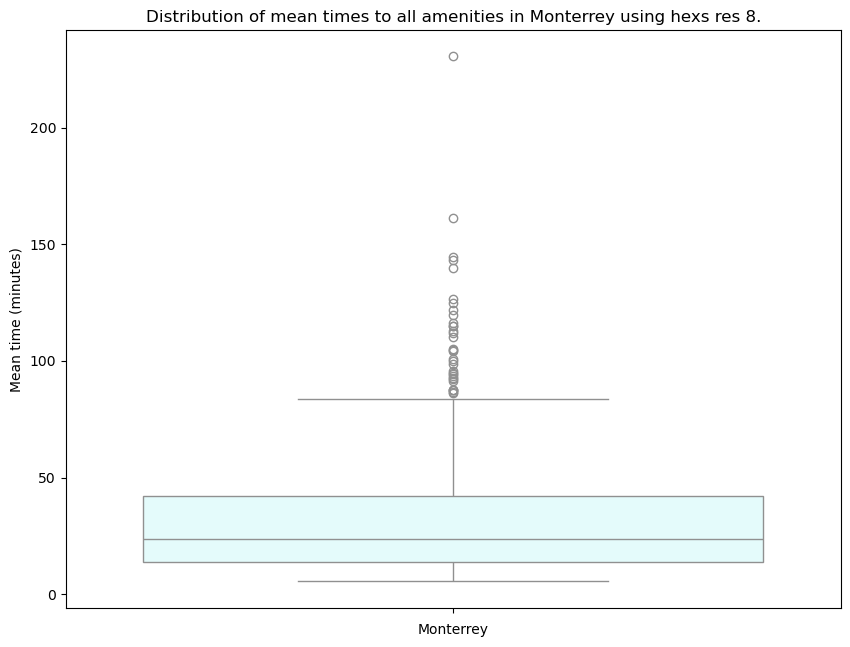

In [9]:
fig,ax = plt.subplots(figsize=(10,7.5))
sns.boxplot(prox_mun_gdf.mean_time,
            color='lightcyan',
            zorder=0,
            ax=ax)
ax.set_title(f'Distribution of mean times to all amenities in {city} using hexs res {res}.')
ax.set_xlabel(f'{city}')
ax.set_ylabel('Mean time (minutes)')

#### Data statistical analysis-Boxplot - __Grouped/categorical boxplot (2 data series)__

Text(0, 0.5, 'Mean time (minutes)')

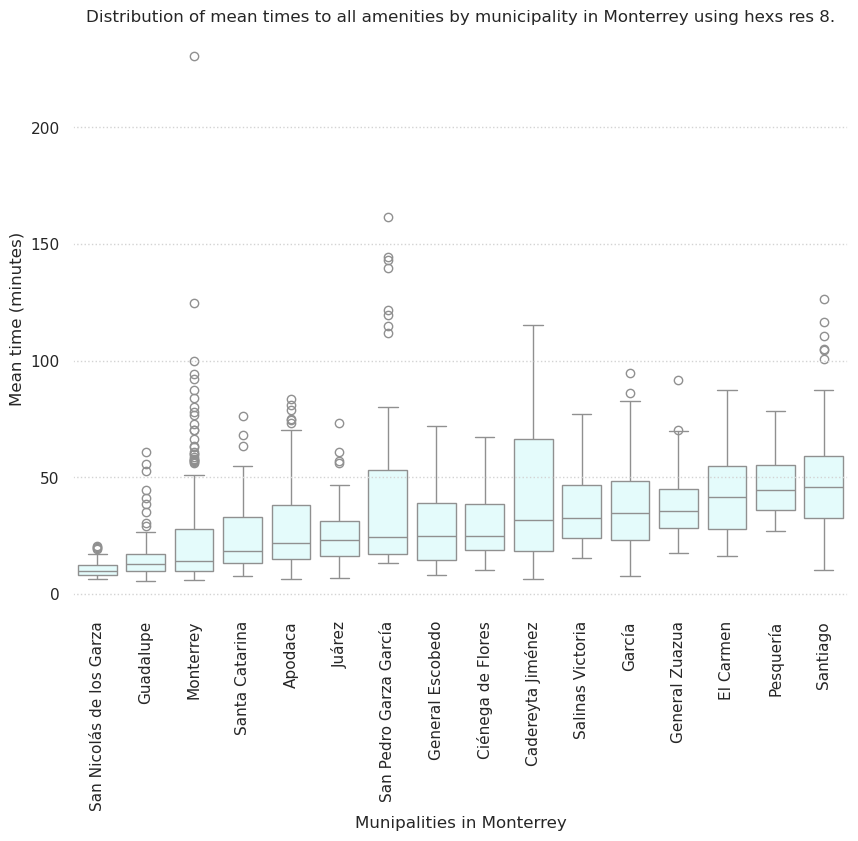

In [160]:
fig,ax = plt.subplots(figsize=(10,7.5))

# Set seaborn style
# More in: https://seaborn.pydata.org/generated/seaborn.axes_style.html#seaborn.axes_style
sns.set_style({'axes.facecolor': 'white',
               "grid.color": "lightgrey",
               "grid.linestyle": ":"
              }
             )

# Calculate order according to median value
order = (
    prox_mun_gdf.groupby("nom_mun")["mean_time"]
    .median()
    .sort_values()
    .index
)

# Plot boxplot
sns.boxplot(x=np.array(prox_mun_gdf.nom_mun), 
            y=np.array(prox_mun_gdf.mean_time),
            order=order, #Set previously calculated order
            zorder=0,
            color='lightcyan',
            ax=ax)

# Format plot
ax.set_title(f'Distribution of mean times to all amenities by municipality in {city} using hexs res {res}.')
ax.set_xlabel(f'Munipalities in {city}')
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('Mean time (minutes)')

### __Data statistical analysis__ - Scatterplot with label points and regplot (data with linear fit)

In [19]:
prox_mun_gdf['area_ha'] = prox_mun_gdf.area/10000
data_grouped = prox_mun_gdf[['mean_time','pobtot','area_ha','nom_mun']].groupby('nom_mun').agg({'pobtot':np.sum,
                                                                                                'area_ha':np.sum,
                                                                                                'mean_time':np.mean})
data_grouped = data_grouped.reset_index()
data_grouped['dens_pob_ha'] = data_grouped['pobtot'] / data_grouped['area_ha']
data_grouped = data_grouped[['nom_mun','dens_pob_ha','mean_time']]

# Show
data_grouped

,nom_mun,dens_pob_ha,mean_time
0,Apodaca,39.623956,28.529614
1,Cadereyta Jiménez,15.198312,42.313100
2,Ciénega de Flores,20.122035,30.165534
3,El Carmen,30.148415,42.555927
4,García,39.044962,37.137146
5,General Escobedo,45.576102,28.894004
6,General Zuazua,21.960193,39.010102
7,Guadalupe,59.361752,15.378941
8,Juárez,46.836311,25.271887
9,Monterrey,47.422281,23.341375


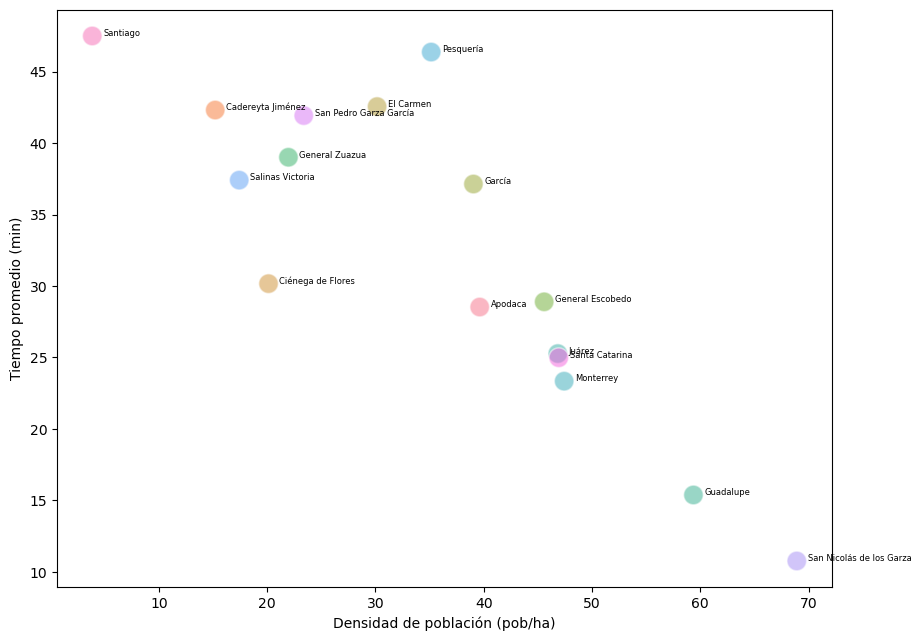

In [42]:
fig,ax = plt.subplots(figsize=(10,7.5))

# Plot scatter
sns.scatterplot(data=data_grouped, 
                x='dens_pob_ha', 
                y='mean_time',
                s=200, 
                alpha=0.5,
                hue = 'nom_mun', 
                legend=False, 
                ax=ax)

# Format plot
plt.xlabel('Densidad de población (pob/ha)')
plt.ylabel('Tiempo promedio (min)')

# Add labels to each individual point
def label_point(x, y, val, ax):
    # Concat x (horizontal position), y (vertical position) and val (value to label) in a DataFrame
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    # For each row, place label
    for i, point in a.iterrows():
        ax.text(point['x']+1, point['y'], str(point['val']),fontsize=6)

label_point(data_grouped.dens_pob_ha, data_grouped.mean_time, data_grouped.nom_mun, plt.gca())

Text(0, 0.5, 'Tiempo promedio ponderado (min)')

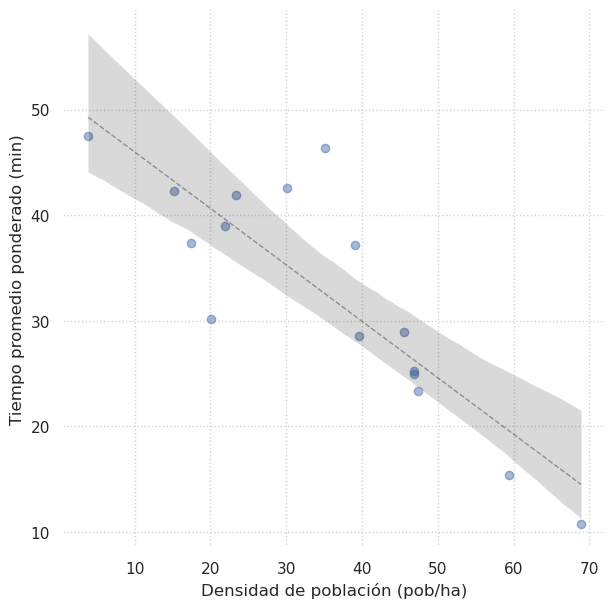

In [209]:
fig,ax = plt.subplots(figsize=(7,7))

# Set seaborn style
# More in: https://seaborn.pydata.org/generated/seaborn.axes_style.html#seaborn.axes_style
sns.set_style({'axes.facecolor': 'white',
               "grid.color": "lightgrey",
               "grid.linestyle": ":"
              }
             )
# Plot regplot
sns.regplot(data=data_grouped, 
            x='dens_pob_ha', 
            y='mean_time', 
            scatter_kws={"alpha":0.5},
            line_kws = {"color": "black", 
                        "linewidth":1,
                        "alpha":0.35, 
                        "linestyle":"dashed"},
            ax=ax)

# Format plot
plt.xlabel('Densidad de población (pob/ha)')
plt.ylabel('Tiempo promedio ponderado (min)')

### __Data statistical analysis__ - Multiple scatter points with correlations

In [43]:
# Correlation calc
import scipy.stats as stats

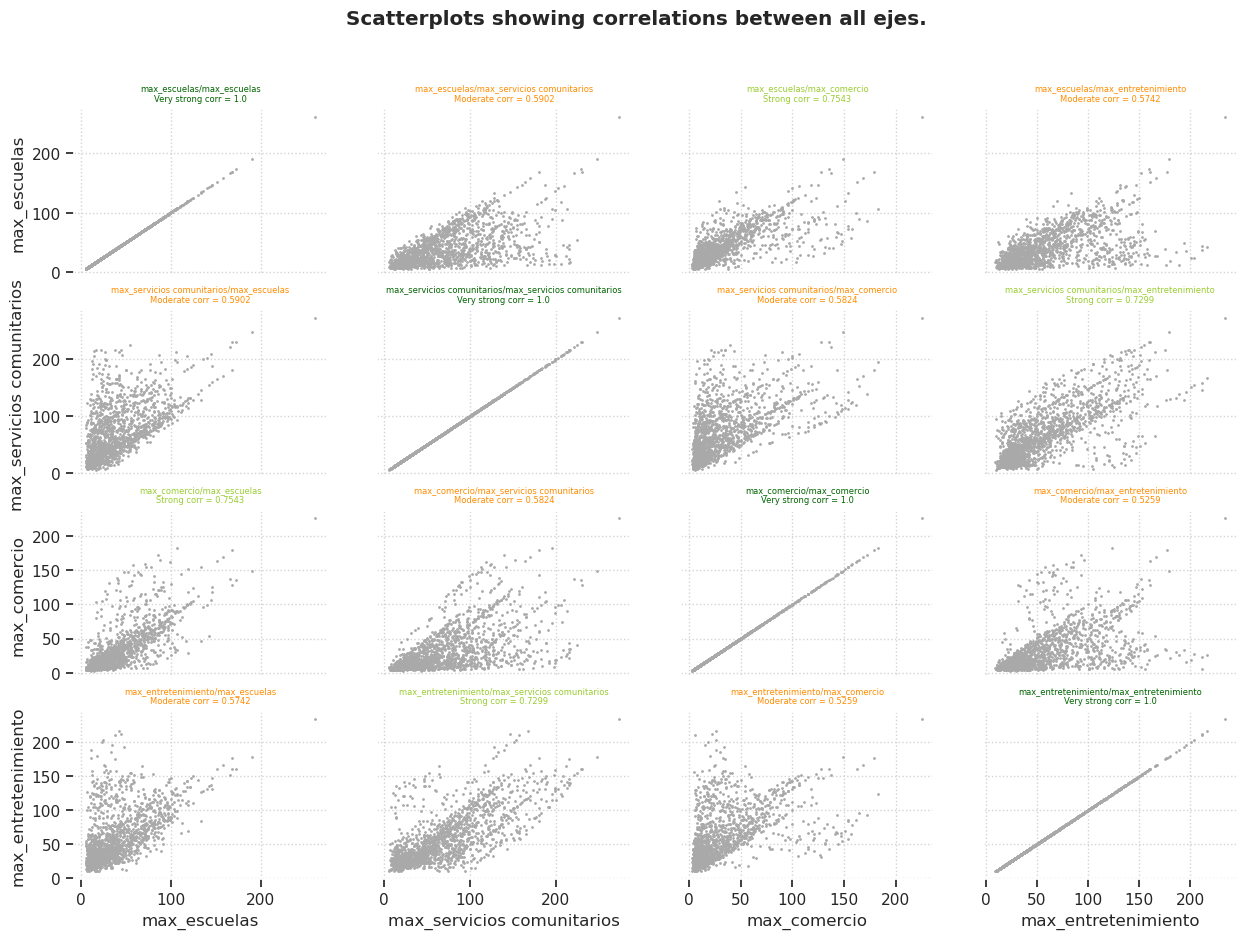

In [210]:
plot_cols = ['max_escuelas','max_servicios comunitarios','max_comercio','max_entretenimiento']

# Subplots grid with n by n combinations (6 data, 6x6)
fig, axs = plt.subplots(len(plot_cols), len(plot_cols), figsize=(15,10))
fig.suptitle("Scatterplots showing correlations between all ejes.",fontweight='bold') # Adds a super title to the figure

# For each col combination
for row in range(len(plot_cols)):

    # For each row
    for col in range(len(plot_cols)):
        
        #Plot scatter
        axs[row,col].scatter(x=prox_mun_gdf[plot_cols[col]], 
                             y=prox_mun_gdf[plot_cols[row]], 
                             s=1,
                             color='darkgray')

        #Correlation
        corr, pval = stats.pearsonr(x=prox_mun_gdf[plot_cols[col]],
                                    y=prox_mun_gdf[plot_cols[row]])
        
        # Correlation categories
        abs_corr = abs(corr)
        if abs_corr > 0.80:
            corr_cat = 'Very strong'
            color='darkgreen'
        elif (abs_corr<0.80) and (abs_corr>0.60):
            corr_cat = 'Strong'
            color = 'yellowgreen'
        elif (abs_corr<0.60) and (abs_corr>0.40):
            corr_cat = 'Moderate'
            color = 'darkorange'
        else:
            corr_cat = 'Weak/very weak'
            color = 'brick'

        # Set title with correlation categories and corr data
        axs[row,col].set_title(f"""{plot_cols[row]}/{plot_cols[col]}
{corr_cat} corr = {round(corr, 4)}""",fontsize=6,color=color)

        # Format - On x axis, turn off tick marks (and labels) except for the last row
        if row == len(plot_cols) - 1:
            axs[row,col].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
            axs[row,col].set_xlabel(plot_cols[col])
        else:
            axs[row,col].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
            
        # Format - On y axis, turn off tick marks (and labels) except for the first column
        if col == 0:
            axs[row,col].tick_params(axis='y', which='both', left=True, labelleft=True)
            axs[row,col].set_ylabel(plot_cols[row])
        else:
            axs[row,col].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

### __Data statistical analysis__ - Correlations heatmap

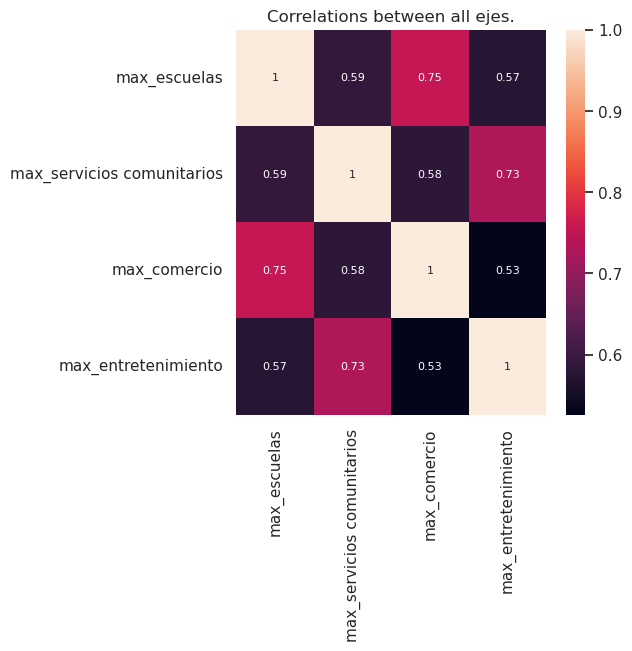

In [161]:
# Isolate data of interest
plot_cols = ['max_escuelas','max_servicios comunitarios','max_comercio','max_entretenimiento']
# Create correlation heatmap
sns.heatmap(prox_mun_gdf[plot_cols].corr(), 
            annot=True, #Place labels inside each colored square
            annot_kws={"fontsize":8}
           )
# Seaborn plot format
sns.set(rc = {'figure.figsize':(5,5)})
# Show
plt.title("Correlations between all ejes.")
plt.show()

### __Data statistical analysis__ - Spiderplot

In [16]:
# Use math to call pi
import math
#
import textwrap

In [7]:
# Summarize values for spider plot
plot_cols = ['max_escuelas','max_servicios comunitarios','max_comercio','max_entretenimiento']
df_polar = prox_mun_gdf[plot_cols].mean(axis=0)

# Turn into transposed df
df = df_polar.copy()
df = pd.DataFrame(df)
df_transposed = df.transpose()

# Rename cols for spider plot
df_transposed = df_transposed.rename(columns={'max_escuelas':'Escuelas',
                                              'max_servicios comunitarios':'Servicios comunitarios',
                                              'max_comercio':'Comercio',
                                              'max_entretenimiento':'Entretenimiento'
                                             }
                                    )

# Show
df_transposed

,Escuelas,Servicios comunitarios,Comercio,Entretenimiento
0,39.350861,69.307022,31.4766,58.298525


In [55]:
def wrap_labels(ax, width, rotation, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, 
                                    width=width,
                                    break_long_words=break_long_words)
                     )
    ax.set_xticklabels(labels, 
                       rotation=rotation)

def make_spider(df, row, color, title, alpha, linewidth, zorder, max_graph_value, graph_div):

    # Set following figure sizes to (5,5) if figsize not passed
    plt.rc('figure', figsize=(5, 5))
    # Create polar ax
    ax = plt.subplot(1,1,1, polar=True) #rows, cols, index, polar

    # ----- SET BASICS FOR PLOT
    # Get values
    # Take all df values (resets index and discards reseted index col with [1:])
    values=df.reset_index().loc[row].values.tolist()[1:]
    # Adds first value to the end of the values list in order to close graph
    values += values[:1]

    # Get angles
    # Get number of categories (columns)
    categories=list(df)[0:]
    N = len(categories)
    # Calculate angle division
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # ----- PLOT
    # Plot spider and its fill according to angles and values
    ax.plot(angles, values, color = color, linewidth=linewidth, linestyle='solid')
    ax.fill(angles, values, color = color, alpha = alpha, zorder=zorder)

    # ----- FORMAT PLOT
    # Format plot - Set starting angle and direction (Influences the plot direction and label positioning)
    # Move starting angle from 0 to the upside of the polar plot (pi/2=90°)
    ax.set_theta_offset(pi / 2)
    # Change angle direction from counterclockwise (1) to clockwise (-1) 
    ax.set_theta_direction(-1)
    
    # Format plot - Set xticks (and its labels) around polar plot
    plt.xticks(angles[:-1], # Omit last angle since when polar plot closes, that point is repeated
               categories, 
               color='black',
               size=8,
               zorder=10)
    # Format plot - Adjust ticks appareance
    ax.tick_params(axis='x',
                   rotation=0, # Prevents labels from rotating around polar plot
                   pad=10,
                   zorder=10)

    # Format plot - Labels inside spiderplot
    # Label positioning inside spiderplot (data)
    ax.set_rlabel_position(0)
    # Create labels according to specified graph divisions
    yticks = [i for i in range(0,max_graph_value+1, graph_div)]
    # Turn into strings
    yticks_lab = [str(y) for y in yticks]
    # Place them
    plt.yticks(yticks, yticks_lab, color="black", size=10, zorder=10)
    # Set y limit (Necessary for adequate visualization)
    plt.ylim(0,max_graph_value)
     
    # Format plot - Wrap labels
    wrap_labels(ax=ax,
                width=8, # Specified width limit that triggers labels warp
                rotation=0,
                break_long_words=True #Wraps labels around specified width
               )

    # Format plot - Set plot title
    plt.title(title, fontsize=10, x = 0.5, y = 1.1)

pi = math.pi

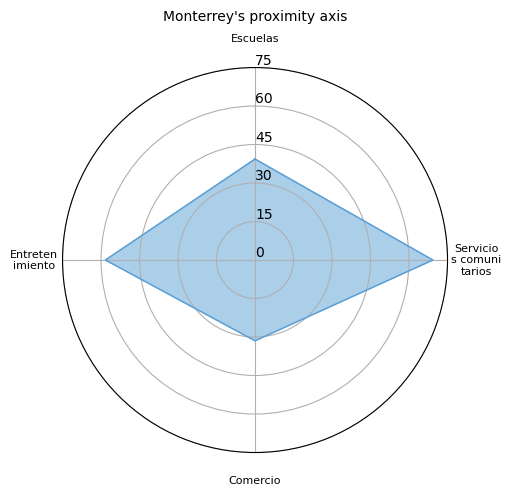

In [56]:
# Plot
color = '#599fd5'
make_spider(row=0, 
            df = df_transposed, 
            title = f"{city}'s proximity axis", 
            color=color, alpha=0.5, linewidth=1, zorder=-1,max_graph_value = 75, graph_div = 15)